In [1]:
import string
import os
import torch
from torch import nn
import random
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden, is_train=True):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        if not is_train:
            return output, hidden
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [3]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

In [4]:
with open('./data/female.txt', mode='r') as f:
    female_names = f.readlines()
with open('./data/male.txt', mode='r') as f:
    male_names = f.readlines()
all_names = [*female_names[6:], *male_names[6:]]
all_names = [name.strip() for name in all_names]

In [5]:
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i, 0, all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[letter]) for letter in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    # test = torch.LongTensor(letter_indexes)
    # if test.ndim != 1:
    #     pdb.set_trace()
    return torch.LongTensor(letter_indexes).unsqueeze_(-1)

In [6]:
all_data = []
for name in all_names:
    all_data.append((inputTensor(name), targetTensor(name)))

In [7]:
def randomTrainingSample(data):
    return random.choice(data)

In [8]:
criterion = nn.NLLLoss()
learning_rate = 0.0005

def train(rnn, input_line_tensor, target_line_tensor):
    # target_line_tensor.unsqueeze(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
rnn = RNN(n_letters, 128, n_letters)
n_iters = 200000
# n_iters = 5000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(rnn, *randomTrainingSample(all_data))
    # print(iter)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0
torch.save(rnn.state_dict(), './rnn.pth')

0m 16s (5000 2%) 2.9412
0m 31s (10000 5%) 2.2180
0m 47s (15000 7%) 1.8579
1m 3s (20000 10%) 2.7842
1m 18s (25000 12%) 2.3911
1m 33s (30000 15%) 1.6452
1m 48s (35000 17%) 1.7046
2m 3s (40000 20%) 2.8889
2m 19s (45000 22%) 2.5953
2m 35s (50000 25%) 2.6794
2m 51s (55000 27%) 2.1092
3m 9s (60000 30%) 2.8420
3m 27s (65000 32%) 1.9483
3m 43s (70000 35%) 2.6473
4m 1s (75000 37%) 2.6915
4m 17s (80000 40%) 2.2528
4m 32s (85000 42%) 2.5359
4m 48s (90000 45%) 2.4071
5m 3s (95000 47%) 2.2831
5m 19s (100000 50%) 2.2601
5m 33s (105000 52%) 4.4384
5m 49s (110000 55%) 2.5999
6m 4s (115000 57%) 2.7329
6m 19s (120000 60%) 2.5166
6m 34s (125000 62%) 1.7271
6m 49s (130000 65%) 2.5746
7m 4s (135000 67%) 2.4523
7m 19s (140000 70%) 1.7445
7m 34s (145000 72%) 1.6523
7m 49s (150000 75%) 2.7453
8m 4s (155000 77%) 2.1362
8m 19s (160000 80%) 1.6422
8m 34s (165000 82%) 1.9875
8m 49s (170000 85%) 2.0277
9m 4s (175000 87%) 3.0686
9m 19s (180000 90%) 2.2655
9m 34s (185000 92%) 1.9176
9m 49s (190000 95%) 2.7945
10m 4s

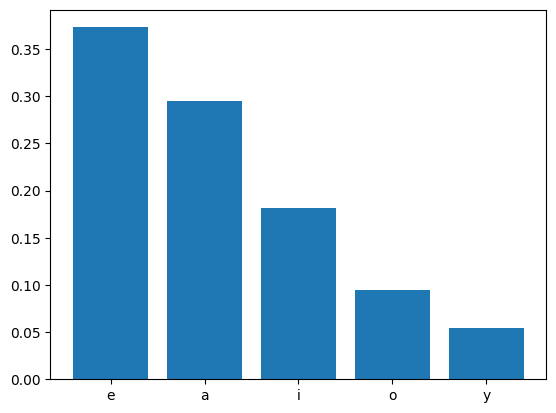

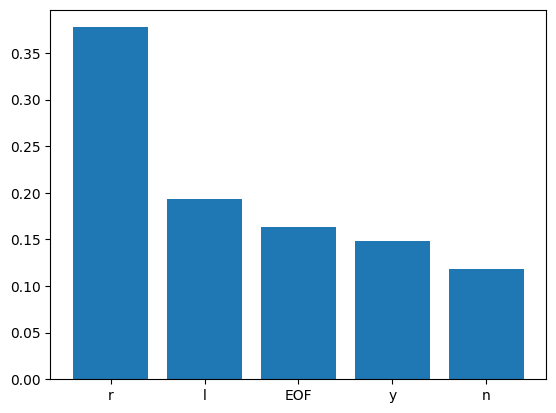

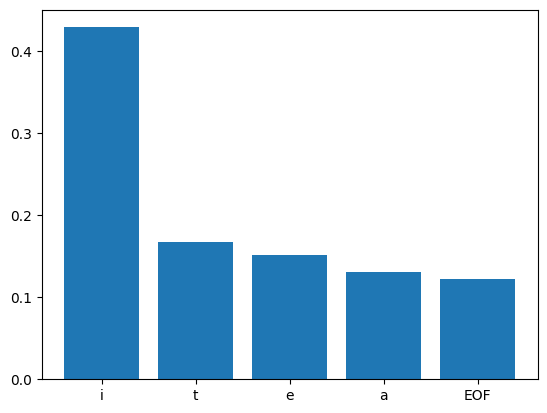

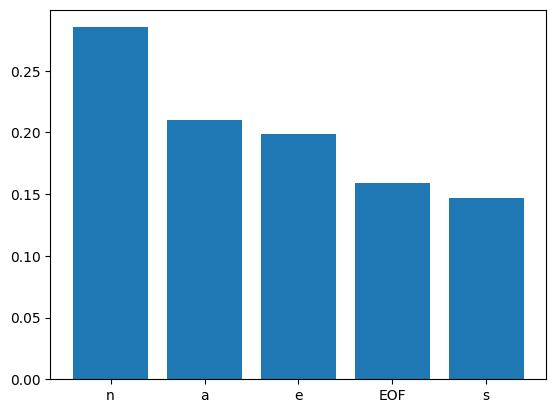

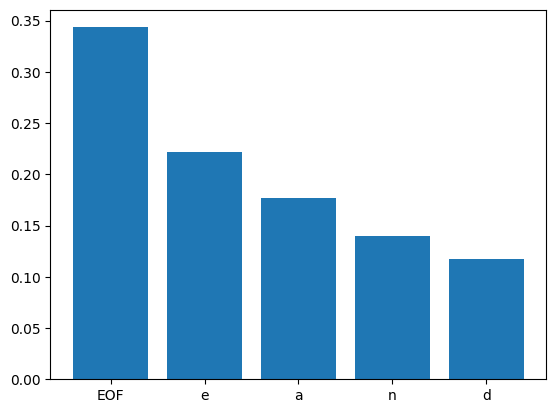

'Skerin'

In [26]:
max_length = 20
rnn.eval()

def plot_topk(topv, topk):
    letters = []
    for i in topk[0]:
        if i == n_letters - 1:
            letters.append('EOF')
        else:
            letters.append(all_letters[i])
    plt.figure()
    topv = nn.functional.softmax(topv, dim=-1).squeeze()
    plt.bar(letters, topv.tolist())
    plt.show()
        

def get_letters(letters, output):
    topv, topi = output.topk(5)
    plot_topk(topv, topi)
    topi = topi[0][0]
    if topi == n_letters - 1:
        return letters, None
    else:
        letter = all_letters[topi]
        letters += letter
    return letters, letter

# Sample from a category and starting letter
def sample(start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        # category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        for i in range(input.size(0)):
            output, hidden = rnn(input[i], hidden, is_train=False)

        output_name, letter = get_letters(start_letter, output)
        if output_name == start_letter:
            return start_letter
        input = inputTensor(letter)

        for i in range(max_length - input.size(0)):
            output, hidden = rnn(input[0], hidden, is_train=False)
            output_name, letter = get_letters(output_name, output)
            if letter is None:
                break
            input = inputTensor(letter)

        return output_name

sample('Sk')

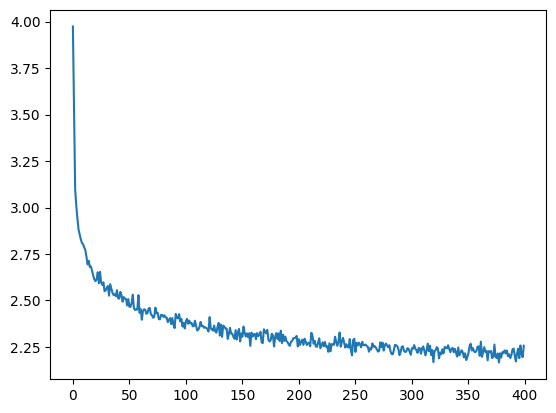

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [27]:
torch.save(all_losses, 'loss.pth')